#### Citation: adapted from Yuan Gong, "Code for the Interspeech 2021 paper 'AST: Audio Spectrogram Transformer' ", https://github.com/YuanGongND/ast/blob/master/colab/AST_Inference_Demo.ipynb

In [2]:
!pip install datasets torchaudio scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86

In [3]:
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.3 MB/s eta 0:00:00


# Common visualization code

In [46]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, TrainingArguments, Trainer, get_scheduler, EarlyStoppingCallback
from datasets import load_dataset, DatasetDict, Dataset
import torch
from sklearn.metrics import accuracy_score
import torchaudio
from collections import Counter

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to resample audio to 16kHz
def resample(audio_array, original_sr, target_sr=16000):
    if original_sr != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=original_sr, new_freq=target_sr)
        audio_array = resampler(torch.tensor(audio_array, dtype=torch.float32).unsqueeze(0)).squeeze(0).numpy()
    return audio_array

# Preprocess function to extract features and handle labels
def preprocess_function(examples):
    audio = examples["audio"]["array"]
    sampling_rate = examples["audio"]["sampling_rate"]
    audio = resample(audio, sampling_rate)
    inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {key: val.squeeze(0) for key, val in inputs.items()}  # Remove batch dimension

    return inputs

# Load feature extractor and model
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Move model to the appropriate device
model.to(device)


Using device: cuda


ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

In [47]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/YuanGongND/ast
    sys.path.append('./ast')
%cd /content/ast/

! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = '/content/ast/pretrained_models'
if os.path.exists('/content/ast/pretrained_models') == False:
  os.mkdir('/content/ast/pretrained_models')
import timm
from torch.cuda.amp import autocast
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

# # Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('/content/ast/pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='/content/ast/pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = '/content/ast/pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("cuda:0"))

Running in Colab.
Cloning into 'ast'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 649 (delta 172), reused 159 (delta 159), pack-reused 440
Receiving objects: 100% (649/649), 2.41 MiB | 27.69 MiB/s, done.
Resolving deltas: 100% (360/360), done.
/content/ast
---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: /content/ast/pretrained_models/audio_mdl.pth


In [48]:
from matplotlib import pyplot as plt
from torch.cuda.amp import autocast
import numpy as np


def plot_spec_and_attention_maps(audio_sample, duration=1024):
  feats_data = torch.tensor(audio_sample["input_values"]).unsqueeze(0).to(device)

  plt.imshow(feats_data[0].t().cpu()[:, :duration], origin='lower', aspect=0.5)
  plt.title('Original Spectrogram')
  plt.show()
  plt.close()
  with torch.no_grad():
    with autocast():
      att_list = audio_model.module.forward_visualization(feats_data)

  # Visualize each layer
  for i in range(len(att_list)):
    att_list[i] = att_list[i].data.cpu().numpy()
    att_list[i] = np.mean(att_list[i][0], axis=0)
    att_list[i] = np.mean(att_list[i][0:2], axis=0)
    att_list[i] = att_list[i][2:].reshape(12, 101)[:, :duration//10]
    plt.imshow(att_list[i], origin='lower', aspect=0.5)
    plt.title('Layer #{:d}'.format(i))
    plt.show()
    plt.close()

# Librispeech

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for librispeech_asr contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/librispeech_asr
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
<ipython-input-18-b3457adc618d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feats_data = torch.tensor(audio_sample["input_values"]).unsqueeze(0).to(device)


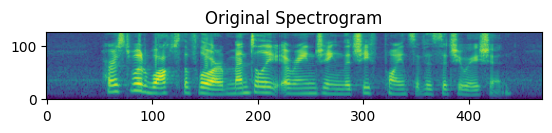

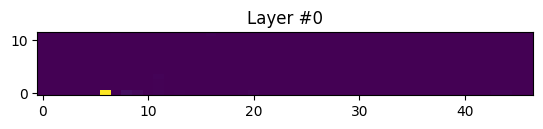

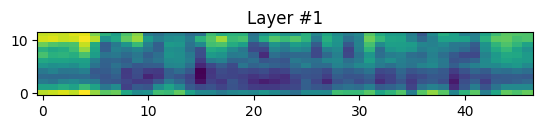

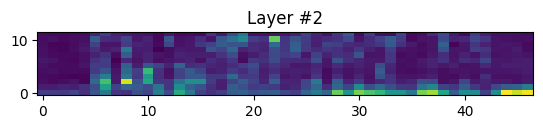

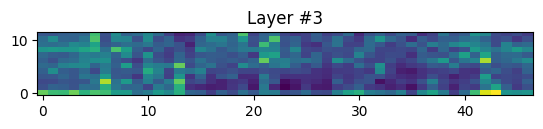

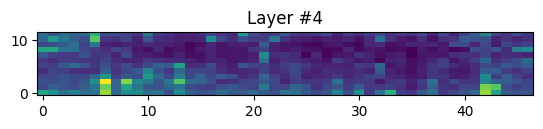

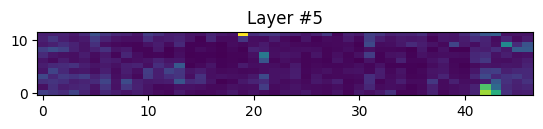

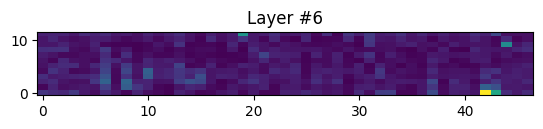

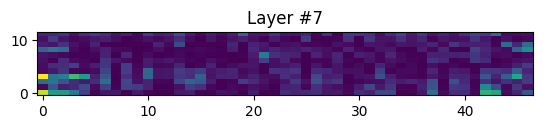

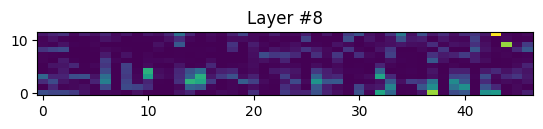

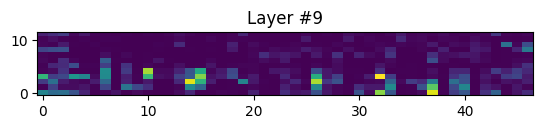

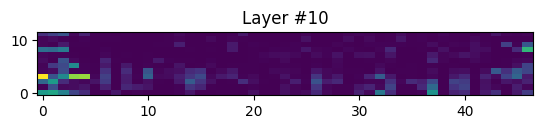

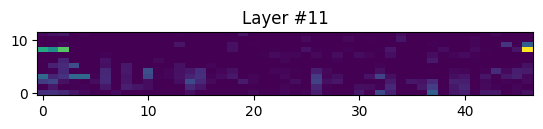

In [21]:
libri_stream = load_dataset("librispeech_asr", "clean", split="validation", streaming=True)
libri = list(libri_stream.take(3))
libri = list(map(preprocess_function, libri))
plot_spec_and_attention_maps(libri[2], 470)

In [ ]:
# Example audio
from IPython.display import Audio, display

file_path = libri[2]["file"]
display(Audio(data=libri[2]["audio"]["array"], autoplay=True, rate=16000))

# Music genre classification

In [24]:
dataset = load_dataset("marsyas/gtzan")

Generating train split: 0 examples [00:00, ? examples/s]

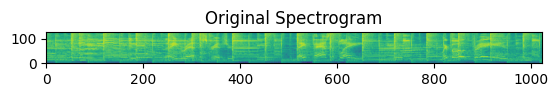

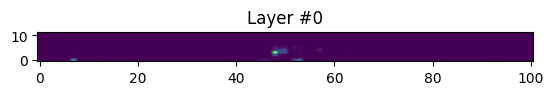

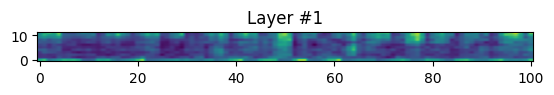

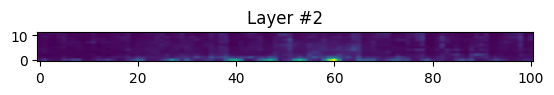

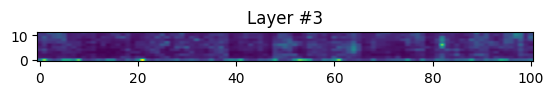

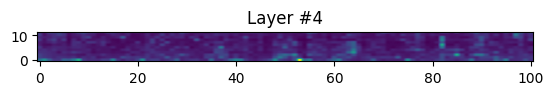

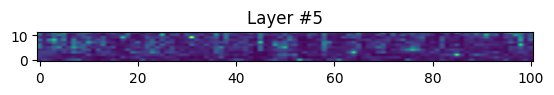

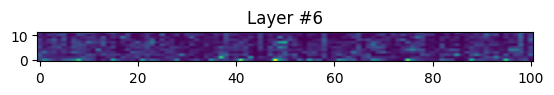

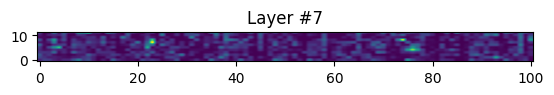

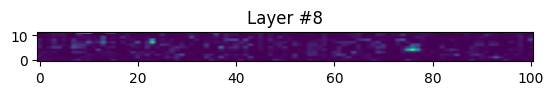

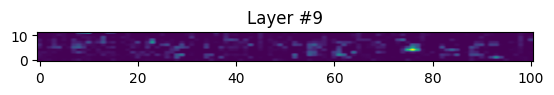

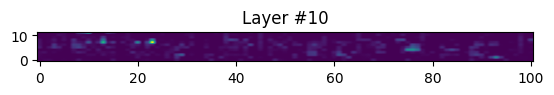

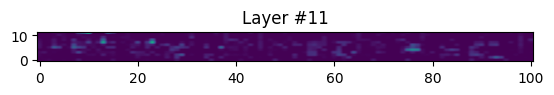

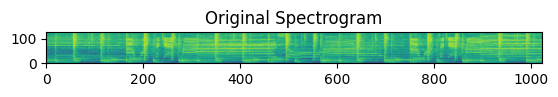

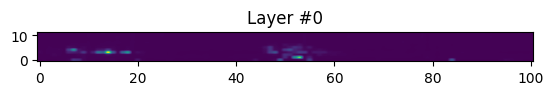

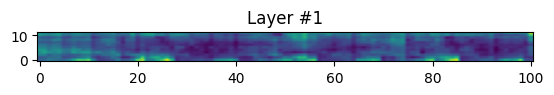

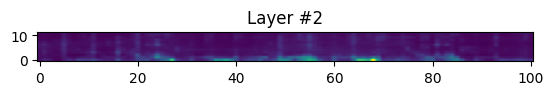

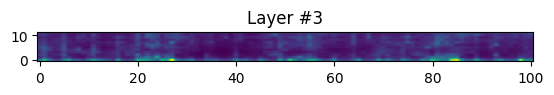

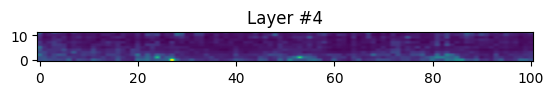

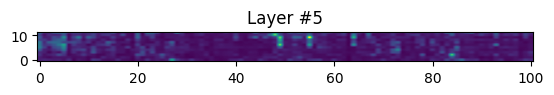

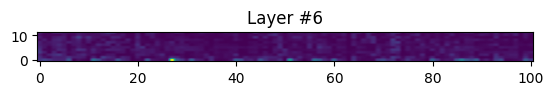

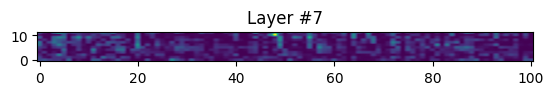

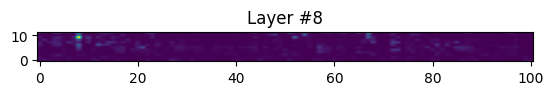

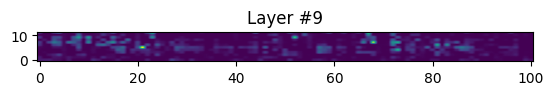

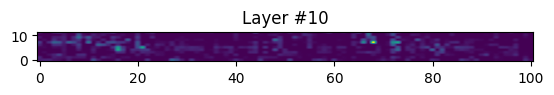

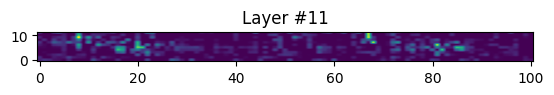

In [58]:
train_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)["train"].select(range(100))
train_dataset = train_dataset.map(preprocess_function, remove_columns=["audio"])

# country track
plot_spec_and_attention_maps(train_dataset[3])
# hiphop track
plot_spec_and_attention_maps(train_dataset[22])

# Emotion recognition

In [59]:
dataset = load_dataset("xbgoose/ravdess")

Generating train split:   0%|          | 0/1440 [00:00<?, ? examples/s]

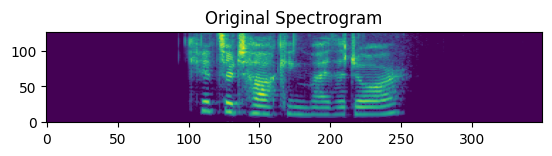

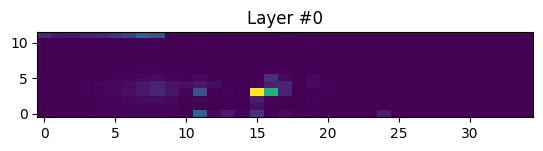

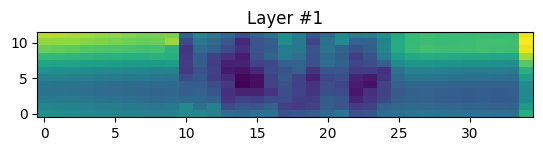

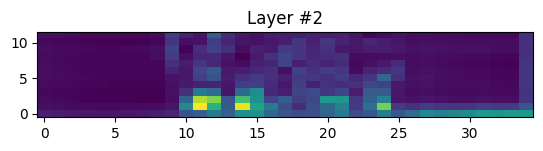

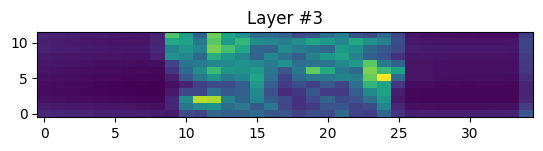

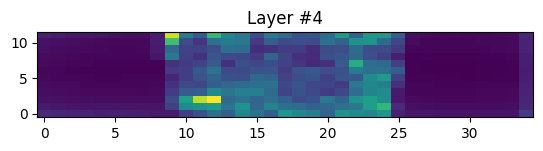

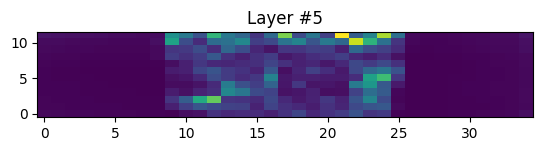

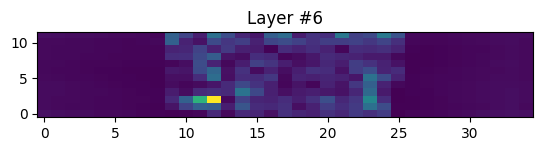

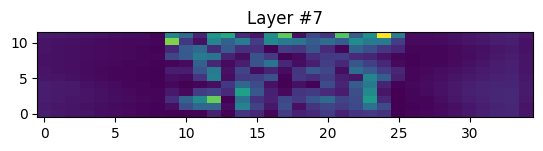

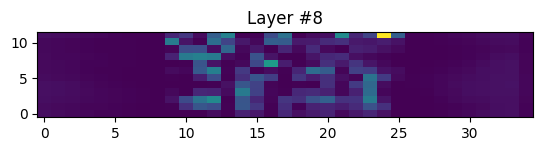

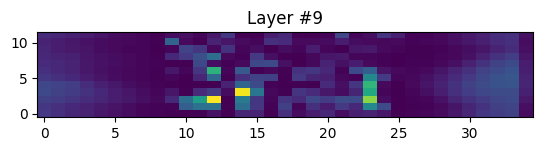

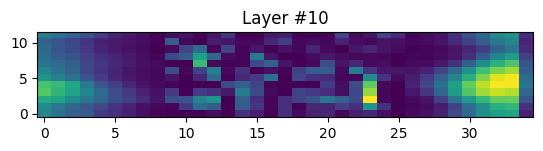

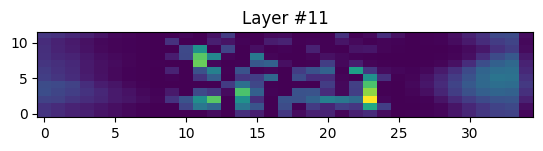

In [62]:
train_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)["train"].select(range(100))
train_dataset = train_dataset.map(preprocess_function, remove_columns=["audio"])
plot_spec_and_attention_maps(train_dataset[0], 350)